# Model Development (App Data)

This notebook consolidates the modelling workflow and leverages reusable helpers
from `src/` for consistent preprocessing and evaluation.

In [1]:
import sys
from pathlib import Path

# Add project root to Python path
ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from src.modelling import build_logistic_pipeline, build_random_forest_pipeline
from src.utils import evaluate_classifier

## 1. Load train/test data

In [2]:
NOTEBOOK_DIR = Path.cwd()
BASE_DIR = NOTEBOOK_DIR.parent
DATA_DIR = BASE_DIR / "Dataset" / "processed"

X_train = pd.read_csv(DATA_DIR / "X_train.csv")
X_test = pd.read_csv(DATA_DIR / "X_test.csv")
y_train = pd.read_csv(DATA_DIR / "y_train.csv").squeeze()
y_test = pd.read_csv(DATA_DIR / "y_test.csv").squeeze()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 96), (10000, 96), (40000,), (10000,))

## 2. Baseline models (with shared evaluation)


=== Logistic Regression ===
Accuracy:  0.767
F1-score:  0.799
ROC AUC:  0.848

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      3785
           1       0.86      0.75      0.80      6215

    accuracy                           0.77     10000
   macro avg       0.76      0.77      0.76     10000
weighted avg       0.78      0.77      0.77     10000



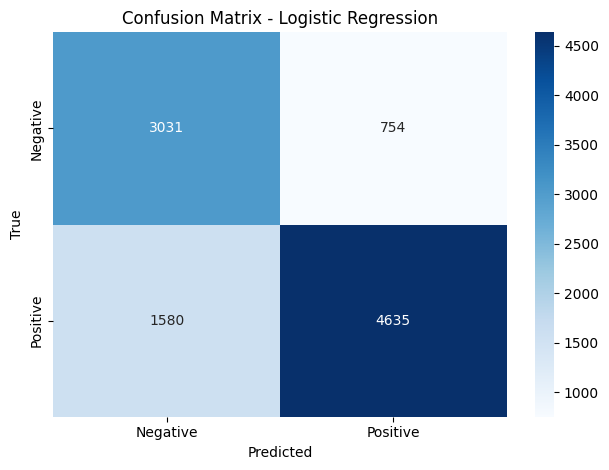


=== Random Forest ===
Accuracy:  0.786
F1-score:  0.824
ROC AUC:  0.869

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      3785
           1       0.85      0.80      0.82      6215

    accuracy                           0.79     10000
   macro avg       0.77      0.78      0.78     10000
weighted avg       0.79      0.79      0.79     10000



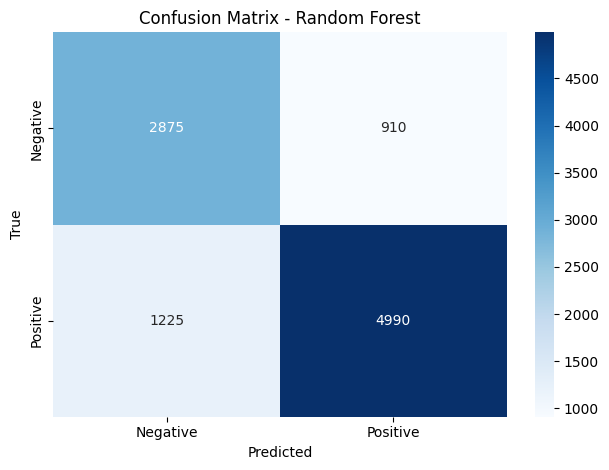

In [3]:
log_reg = build_logistic_pipeline(X_train)
rf = build_random_forest_pipeline(X_train)

# Uses shared evaluation helper from src/utils.py
_ = evaluate_classifier("Logistic Regression", log_reg, X_train, X_test, y_train, y_test)
_ = evaluate_classifier("Random Forest", rf, X_train, X_test, y_train, y_test)

## 3. ROC curve comparison

<Figure size 800x600 with 0 Axes>

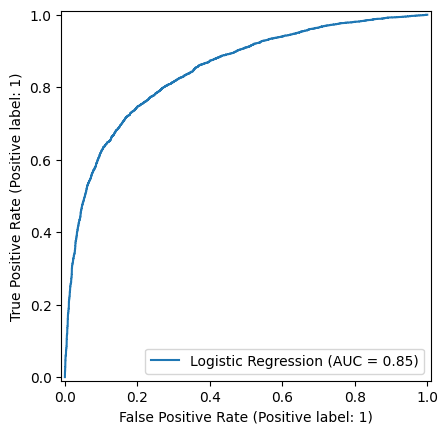

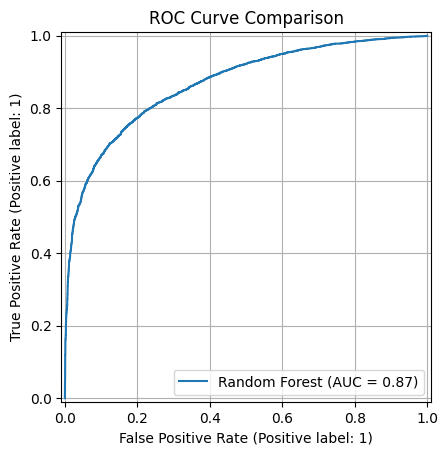

In [4]:
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

proba_lr = log_reg.predict_proba(X_test)[:, 1]
proba_rf = rf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, proba_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, proba_rf, name="Random Forest")
plt.title("ROC Curve Comparison")
plt.grid(True)
plt.show()

## 4. Random Forest feature importance

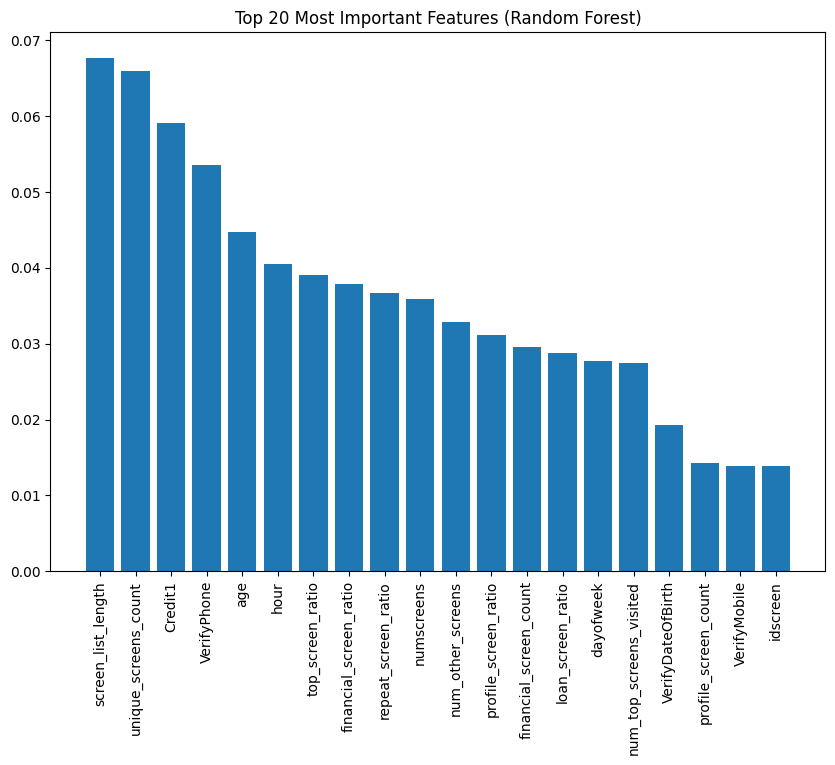

In [5]:
rf_model = rf.named_steps["model"]
preprocessor = rf.named_steps["preprocess"]

feature_names = preprocessor.transformers_[0][2]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 7))
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), np.array(feature_names)[indices][:20], rotation=90)
plt.title("Top 20 Most Important Features (Random Forest)")
plt.show()

## 5. Hyperparameter tuning (Random Forest)

In [6]:
param_grid = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
}

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best ROC AUC:", grid.best_score_)

Best params: {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Best ROC AUC: 0.8605240367590118


## 6. XGBoost 

This section runs only if `xgboost` is installed.


xgboost version: 3.1.2

=== XGBoost ===
Accuracy:  0.795
F1-score:  0.837
ROC AUC:  0.876

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      3785
           1       0.83      0.85      0.84      6215

    accuracy                           0.80     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.79      0.80      0.79     10000



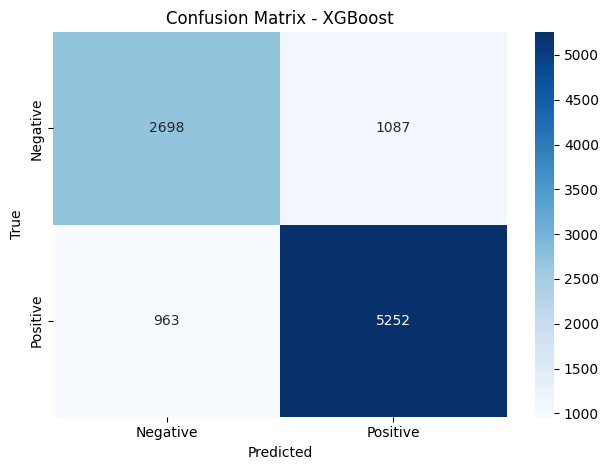

<Figure size 800x600 with 0 Axes>

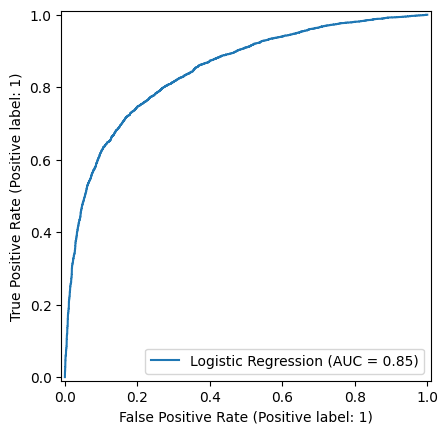

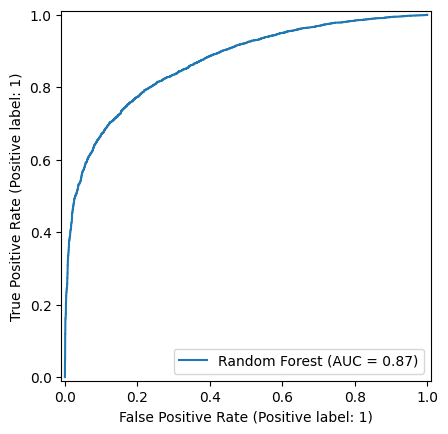

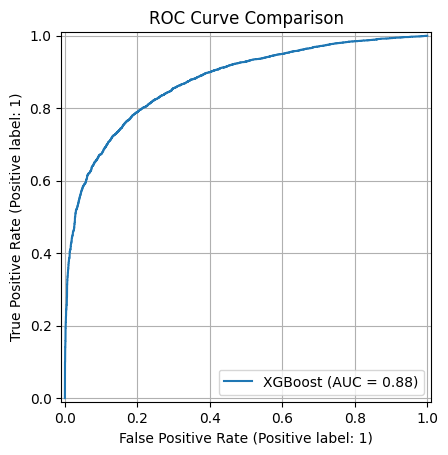

In [7]:
try:
    import xgboost as xgb
    from xgboost import XGBClassifier

    print("xgboost version:", xgb.__version__)

    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train_num = X_train[num_cols]
    X_test_num = X_test[num_cols]

    xgb_model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
    )

    _ = evaluate_classifier("XGBoost", xgb_model, X_train_num, X_test_num, y_train, y_test)

    proba_xgb = xgb_model.predict_proba(X_test_num)[:, 1]

    plt.figure(figsize=(8, 6))
    RocCurveDisplay.from_predictions(y_test, proba_lr, name="Logistic Regression")
    RocCurveDisplay.from_predictions(y_test, proba_rf, name="Random Forest")
    RocCurveDisplay.from_predictions(y_test, proba_xgb, name="XGBoost")
    plt.title("ROC Curve Comparison")
    plt.grid(True)
    plt.show()

except ImportError as exc:
    print("xgboost not installed; skipping XGBoost section.")
    print(exc)

## 7. Cross-validated performance

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_cv = {
    "Logistic Regression": build_logistic_pipeline(X_train),
    "Random Forest": build_random_forest_pipeline(X_train),
}

# Add XGBoost to CV if available
try:
    from xgboost import XGBClassifier

    models_cv["XGBoost"] = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
    )
except ImportError:
    pass

results_cv = []

for name, model in models_cv.items():
    if name == "XGBoost":
        num_cols = X_train.select_dtypes(include=[np.number]).columns
        X_cv = X_train[num_cols]
    else:
        X_cv = X_train

    auc_scores = cross_val_score(
        model,
        X_cv,
        y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    )

    f1_scores = cross_val_score(
        model,
        X_cv,
        y_train,
        cv=cv,
        scoring="f1",
        n_jobs=-1,
    )

    results_cv.append({
        "Model": name,
        "ROC AUC (mean)": auc_scores.mean(),
        "ROC AUC (std)": auc_scores.std(),
        "F1 (mean)": f1_scores.mean(),
        "F1 (std)": f1_scores.std(),
    })

pd.DataFrame(results_cv)

,Model,ROC AUC (mean),ROC AUC (std),F1 (mean),F1 (std)
0,Logistic Regression,0.841858,0.003143,0.791283,0.003464
1,Random Forest,0.861362,0.003592,0.818734,0.005522
2,XGBoost,0.868945,0.003021,0.831031,0.003970


## 8. Calibration and thresholding (XGBoost)

Runs only if `xgboost` is installed.


Brier score (uncalibrated XGB): 0.13890341285855679
Brier score (calibrated XGB): 0.13889658402167032


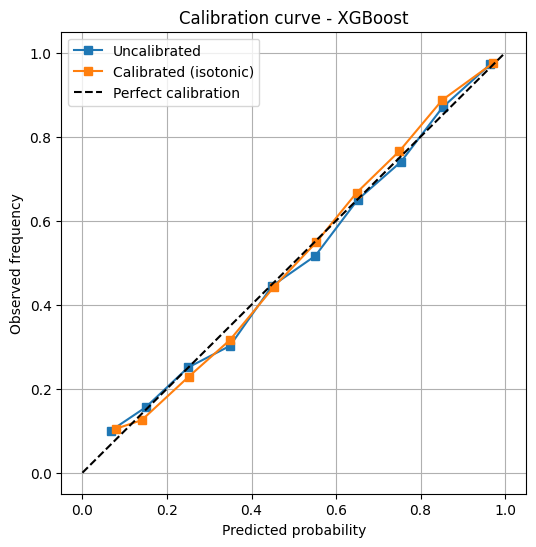

Best cost threshold: threshold        0.190000
fp            2894.000000
fn             116.000000
total_cost    3358.000000
F1               0.802078
Name: 9, dtype: float64
Best F1 threshold: threshold        0.460000
fp            1206.000000
fn             845.000000
total_cost    4586.000000
F1               0.839653
Name: 36, dtype: float64


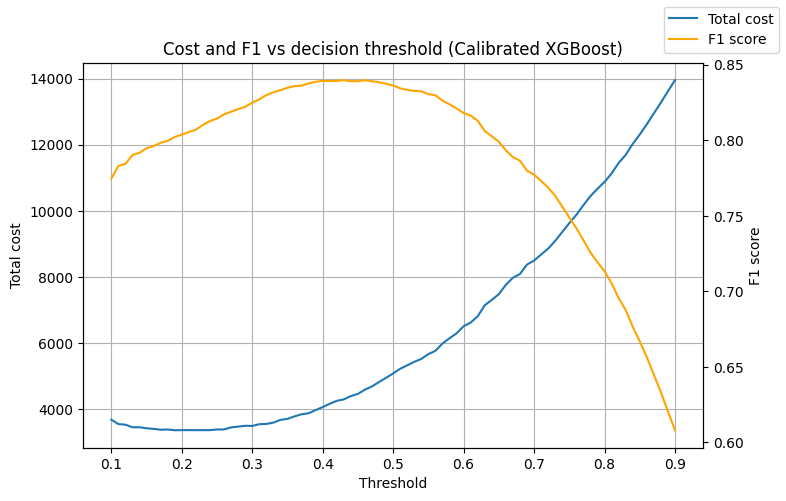

In [9]:
try:
    from sklearn.calibration import calibration_curve, CalibratedClassifierCV
    from sklearn.metrics import brier_score_loss
    from xgboost import XGBClassifier

    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train_num = X_train[num_cols]
    X_test_num = X_test[num_cols]

    xgb_uncal = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
    )
    xgb_uncal.fit(X_train_num, y_train)
    y_proba_uncal = xgb_uncal.predict_proba(X_test_num)[:, 1]

    brier_uncal = brier_score_loss(y_test, y_proba_uncal)
    print("Brier score (uncalibrated XGB):", brier_uncal)

    prob_true_uncal, prob_pred_uncal = calibration_curve(
        y_test, y_proba_uncal, n_bins=10
    )

    xgb_cal = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
    )

    calibrated = CalibratedClassifierCV(
        estimator=xgb_cal,
        method="isotonic",
        cv=3,
    )
    calibrated.fit(X_train_num, y_train)
    y_proba_cal = calibrated.predict_proba(X_test_num)[:, 1]

    brier_cal = brier_score_loss(y_test, y_proba_cal)
    print("Brier score (calibrated XGB):", brier_cal)

    prob_true_cal, prob_pred_cal = calibration_curve(
        y_test, y_proba_cal, n_bins=10
    )

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred_uncal, prob_true_uncal, "s-", label="Uncalibrated")
    plt.plot(prob_pred_cal, prob_true_cal, "s-", label="Calibrated (isotonic)")
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title("Calibration curve - XGBoost")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Threshold analysis
    cost_fp = 1
    cost_fn = 4

    thresholds = np.linspace(0.1, 0.9, 81)
    records = []

    for thr in thresholds:
        y_pred_thr = (y_proba_cal >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr).ravel()

        total_cost = cost_fp * fp + cost_fn * fn
        f1 = f1_score(y_test, y_pred_thr)

        records.append({
            "threshold": thr,
            "fp": fp,
            "fn": fn,
            "total_cost": total_cost,
            "F1": f1,
        })

    thr_df = pd.DataFrame(records)
    best_cost_row = thr_df.loc[thr_df["total_cost"].idxmin()]
    best_f1_row = thr_df.loc[thr_df["F1"].idxmax()]

    print("Best cost threshold:", best_cost_row)
    print("Best F1 threshold:", best_f1_row)

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(thr_df["threshold"], thr_df["total_cost"], label="Total cost")
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Total cost")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(thr_df["threshold"], thr_df["F1"], label="F1 score", color="orange")
    ax2.set_ylabel("F1 score")

    fig.legend(loc="upper right")
    plt.title("Cost and F1 vs decision threshold (Calibrated XGBoost)")
    plt.show()

except ImportError as exc:
    print("xgboost not installed; skipping calibration and thresholding.")
    print(exc)

## 9. SHAP explanation (optional)

Runs only if `shap` is installed and XGBoost was fitted.


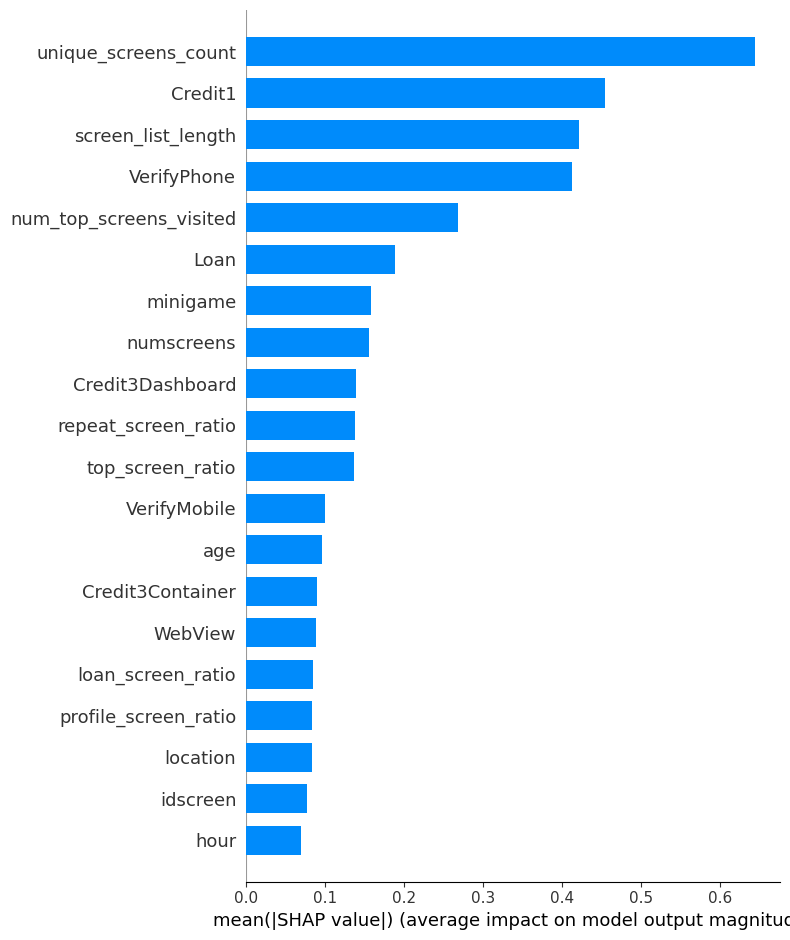

In [10]:
try:
    import shap

    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train_num = X_train[num_cols]
    X_test_num = X_test[num_cols]

    xgb_model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
    )
    xgb_model.fit(X_train_num, y_train)

    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test_num)

    shap.summary_plot(shap_values, X_test_num, plot_type="bar")

except Exception as exc:
    print("Skipping SHAP section.")
    print(exc)